In [40]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim


In [97]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # can use bias=False bc of batch normalization
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False), # can use bias=False bc of batch normalization
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [98]:
class UNET(nn.Module):
    def __init__(self, 
                in_channels = 40,
                out_channels = 1,
                features = [64,128,256,512] # sizes of feature map for each convolution layer
                ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList() # down convolutions
        self.ups = nn.ModuleList() # up convolutions
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # max pooling layers

        # down convolutions
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature)) # convolve feature pair
            in_channels = feature # continue loop to next feature pair

        # up convolutions, working in reverse order of features
        for feature in reversed(features):
            self.ups.append(
                # double feature size
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2)
                # double convolution
            )
            self.ups.append(DoubleConv(feature*2, feature))
        

        # bottom of U
        self.bottleneck = DoubleConv(features[-1], features[-1]*2) # reach 1024

        # output convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1] # reverse skip_connections

        # up then conv, up then conv
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # int div by 2

            # if img is not divisible by 16
            # resize to the bottom layer size
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1) # add along channel dimension
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
            

In [99]:
def test():
    x = torch.randn((3,1,160,160))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

In [100]:
test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


(-0.5, 39.5, 39.5, -0.5)

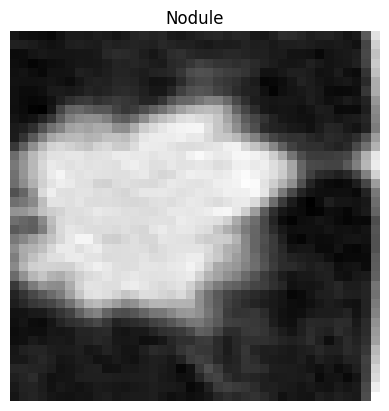

In [101]:
roi_img_list_path = 'data/training_scans/'
roi_img_path = os.listdir(roi_img_list_path)

scans = []
for img in roi_img_path:
    scans.append(sitk.GetArrayFromImage(sitk.ReadImage(roi_img_list_path + img)))

plt.imshow(scans[0][20,:,:], cmap='gray')
plt.title('Nodule')
plt.axis('off')

(-0.5, 39.5, 39.5, -0.5)

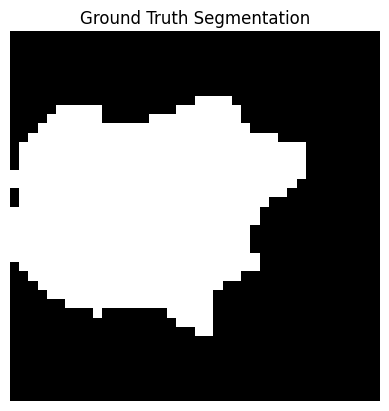

In [102]:
seg_img_list_path = 'data/training_labels'
seg_img_path = os.listdir(seg_img_list_path)

segs = []
for seg in seg_img_path:
    if seg != '.DS_Store':
        segs.append(sitk.GetArrayFromImage(sitk.ReadImage(seg_img_list_path + '/' + seg)))

plt.imshow(segs[0][20,:,:], cmap = 'gray')
plt.title('Ground Truth Segmentation')
plt.axis('off')

(-0.5, 39.5, 39.5, -0.5)

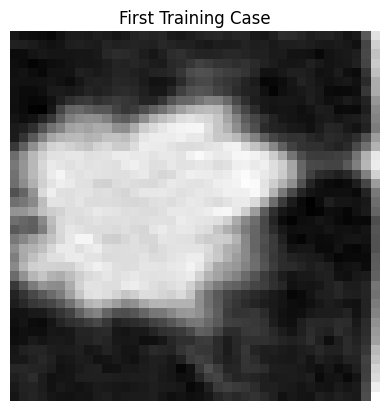

In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(scans, dtype='float32'), np.array(segs, dtype='float32'), test_size=2, random_state=42)

plt.imshow(X_train[0][20,:,:], cmap='gray')
plt.title('First Training Case')
plt.axis('off')

In [104]:
lr = 1e-4
device = 'mps'
batch_size = 16
epochs = 3

X_train = torch.from_numpy(X_train).to(device)
Y_train = torch.from_numpy(Y_train).to(device)
X_test = torch.from_numpy(X_test).to(device)
Y_test = torch.from_numpy(Y_test).to(device)

In [105]:
def train(model, X_train, X_test, Y_train, Y_test, optimizer, loss_function, scaler):

    loss_history = []
    
    for epoch in range(epochs):

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(X_train)
            loss = loss_function(predictions, Y_train)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update loss loop
        loss_history.append(loss.item())
    
    # Plot loss per epoch
    fig, ax = plt.subplots()
    ax.plot(nn_history)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
        

In [108]:
model = UNET(in_channels=40, out_channels=1).to(device) # change out channels for multi-class seg
loss_function = nn.BCEWithLogitsLoss() # change to cross-entropy loss for multi class seg
optimizer = optim.Adam(model.parameters(), lr=lr)

scaler = torch.amp.GradScaler('mps')


In [109]:
train(model, X_train, X_test, Y_train, Y_test, optimizer, loss_function, scaler)

/var/folders/68/1z1fb9gn1ms2d92z8jtw0hzm0000gn/T/ipykernel_84198/3736608149.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


NotImplementedError: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.